# Acceso a pronósticos GFS en la nube

---

```{image} ../images/forecast.png
:alt: Modelo de pronóstico global mostrando campos atmosféricos
:width: 100%
:align: center
```

## Introducción

En este cuaderno aprenderás a acceder y analizar pronósticos del **Global Forecast System (GFS)** utilizando **ArrayLake**, un servicio de repositorios Zarr en la nube que proporciona acceso eficiente a datos de modelos de pronóstico.

GFS es el modelo de pronóstico numérico del tiempo operado por el Centro Nacional de Predicción Ambiental (NCEP) de Estados Unidos. Genera pronósticos de hasta 16 días para docenas de variables atmosféricas y de superficie terrestre, incluyendo temperatura, vientos, precipitación, humedad y nubosidad. El modelo se ejecuta 4 veces al día (00z, 06z, 12z, 18z) y es ampliamente utilizado como condición inicial para modelos regionales.

Los datos que utilizaremos provienen del repositorio **`earthmover-public/gfs`** en ArrayLake, que contiene pronósticos del GFS en formato **Zarr v3 / Icechunk** con resolución de 0.25° (~28 km). El grupo `solar` incluye variables clave para aplicaciones meteorológicas y de energía renovable.

## 📚 Descripción general

En este cuaderno aprenderás a:

1. Comprender qué es el modelo GFS y su importancia en pronóstico meteorológico
2. Acceder a pronósticos GFS en formato Zarr v3 mediante ArrayLake
3. Explorar variables de superficie relevantes para meteorología operacional
4. Generar mapas de pronóstico para regiones específicas (ej. Colombia)
5. Visualizar series temporales de pronóstico para ubicaciones puntuales

---

## ✅ Requisitos previos

| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Introducción a Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necesario | Manipulación de arreglos multidimensionales |
| [Xarray: Lectura de datos](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#opening-netcdf-data) | Necesario | Apertura de conjuntos de datos Zarr |
| [Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necesario | Visualización de mapas y proyecciones |
| [Introducción a Datetime](https://foundations.projectpythia.org/core/datetime/datetime.html) | Útil | Manejo de estampas de tiempo |
| [Formato Zarr](../1.fundamentos/1.8.Formato-Zarr.ipynb) | Útil | Comprensión de formatos cloud-nativos |
| Conceptos de pronóstico numérico | Útil | Interpretación de salidas de modelos |

⏱️ **Tiempo estimado de aprendizaje**: 30–40 minutos

✍️ **Formato**: Interactivo

---

## Librerías

Importamos las librerías necesarias para trabajar con ArrayLake y visualizar pronósticos.

In [1]:
from arraylake import Client
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta

### Autenticación con ArrayLake

ArrayLake es un servicio de repositorios Zarr en la nube que proporciona acceso eficiente a grandes datasets como GFS. Para usar ArrayLake:

1. **En Binder/JupyterHub**: Ejecuta `client.login()` y sigue las instrucciones para autenticarte
2. **En GitHub Actions**: Las credenciales se gestionan mediante secrets del repositorio

```{note}
ArrayLake almacena tu token en `~/.arraylake/token.json`. Solo necesitas autenticarte una vez por sesión.
```

In [2]:
client = Client()
client.login()  # Solo necesario la primera vez por sesión

🔓 Successfully refreshed tokens!

> Token stored at /home/alfonso/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Alfonso Ladino Rincon                                                                                     │
│ Email: alfonso8@illinois.edu                                                                                    │
│ Id: 07979de4-86d6-4a48-90fd-485ac4312916                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔓 Successfully logged in!

> Token stored at /home/alfonso/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Alfonso Ladino Rincon                                                                                     │
│ Email: alfonso8@illinois.edu                                                                                    │
│ Id: 07979de4-86d6-4a48-90fd-485ac4312916                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
repo = client.get_repo("earthmover-public/gfs")

# Establecer vista de solo lectura del branch "main" inmutable
session = repo.readonly_session("main")

## 1. 🌍 Introducción al modelo GFS

El **Global Forecast System (GFS)** es el modelo de pronóstico numérico del tiempo operado por el Centro Nacional de Predicción Ambiental (NCEP) de Estados Unidos.

### 1.1. 📌 Características principales

- ✅ **Cobertura global**: Pronósticos para todo el planeta
- ⏱️ **Frecuencia de ejecución**: 4 veces al día (00z, 06z, 12z, 18z)
- 📅 **Alcance del pronóstico**: Hasta 16 días
- 🌐 **Resolución espacial**: 0.25° (~28 km)
- 📈 **Niveles verticales**: 127 capas en la atmósfera
- 🔢 **Sistema de grilla**: Esfera cúbica de volumen finito (FV3)

### 1.2. 📎 Aplicaciones

- 🌦️ Pronóstico meteorológico operacional
- 🌊 Condiciones iniciales para modelos regionales (WRF, etc.)
- ☀️ Predicción de generación de energía solar y eólica
- ✈️ Planificación de aviación y navegación marítima
- 🌾 Agricultura y gestión de recursos hídricos

💡 **Nota:** GFS es ampliamente utilizado como condición inicial y de frontera para modelos regionales de mayor resolución.

## 2. ☁️ Acceso a datos GFS con ArrayLake

El conjunto de datos GFS está disponible a través de **ArrayLake** en el repositorio `earthmover-public/gfs`. Esta versión contiene:

- ✅ **Variables del grupo "solar"**: temperatura 2m, nubosidad, humedad, precipitación, ráfagas
- 📅 **Periodo**: Mayo 2024 - presente (actualizado cada 6 horas)
- 🌐 **Resolución espacial**: 0.25° (1440×721 puntos)
- ⏱️ **Resolución temporal**: Horaria, pronósticos hasta 16 días
- 💾 **Formato**: Zarr v3 / Icechunk

### Variables disponibles en el grupo "solar"

| Variable | Descripción | Unidades |
| --- | --- | --- |
| `t2m` | Temperatura a 2 metros | K |
| `r2` | Humedad relativa a 2 metros | % |
| `tcc` | Cobertura de nubes total | fracción (0-1) |
| `prate` | Tasa de precipitación | kg/m²/s |
| `gust` | Ráfaga de viento | m/s |

### 2.1. 🔓 Apertura del conjunto de datos

In [4]:
%%time
ds_gfs = xr.open_dataset(
    session.store,
    engine="zarr",
    consolidated=False,
    zarr_format=3,
    chunks={},
    group="solar"  # Grupo con variables de superficie
)

CPU times: user 400 ms, sys: 36.7 ms, total: 437 ms
Wall time: 637 ms


In [5]:
display(ds_gfs)

<xarray.Dataset> Size: 1TB
Dimensions:    (longitude: 1440, latitude: 721, time: 252, step: 209)
Coordinates:
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2kB 2025-08-25T18:00:00 ... 2025-10-27T1...
  * step       (step) timedelta64[h] 2kB 00:00:00 01:00:00 ... 16 days 00:00:00
Data variables:
    r2         (longitude, latitude, time, step) float32 219GB dask.array<chunksize=(360, 120, 1, 24), meta=np.ndarray>
    prate      (longitude, latitude, time, step) float32 219GB dask.array<chunksize=(360, 120, 1, 24), meta=np.ndarray>
    t2m        (longitude, latitude, time, step) float32 219GB dask.array<chunksize=(360, 120, 1, 24), meta=np.ndarray>
    gust       (longitude, latitude, time, step) float32 219GB dask.array<chunksize=(360, 120, 1, 24), meta=np.ndarray>
    tcc        (longitude, latitude, time, step) float32 219GB dask.array<chunksize=(360, 120, 1, 24), meta=np.ndarray>
Attributes:
    description:  GFS data ingested for forecasting demo

### 2.2. 📋 Exploración del conjunto de datos

El conjunto de datos contiene:

- ➕ **5 variables de superficie** (t2m, r2, tcc, prate, gust)
- 📐 **Dimensiones**: time × latitude (721) × longitude (1440)
- 🌍 **Coordenadas**: latitudes -90° → 90°, longitudes 0° → 360°
- 💾 **Formato**: Zarr v3 / Icechunk optimizado para consultas en la nube

## 3. 🗺️ Visualización de pronósticos

Comencemos visualizando el pronóstico de temperatura para el día de mañana.

### 3.1. 🌍 Mapa global de temperatura

In [6]:
# Calcular fecha de mañana
tomorrow = datetime.now() + timedelta(days=1)
fecha_str = f"{tomorrow:%Y-%m-%d}"

print(f"Pronóstico para: {fecha_str}")

Pronóstico para: 2025-10-28


In [20]:
# Seleccionar temperatura para mañana al mediodía
t2m_forecast = ds_gfs.t2m.sel(time=f"{fecha_str} 12:00", method="nearest")

# Convertir de Kelvin a Celsius
t2m_celsius = t2m_forecast - 273.15
t2m_celsius

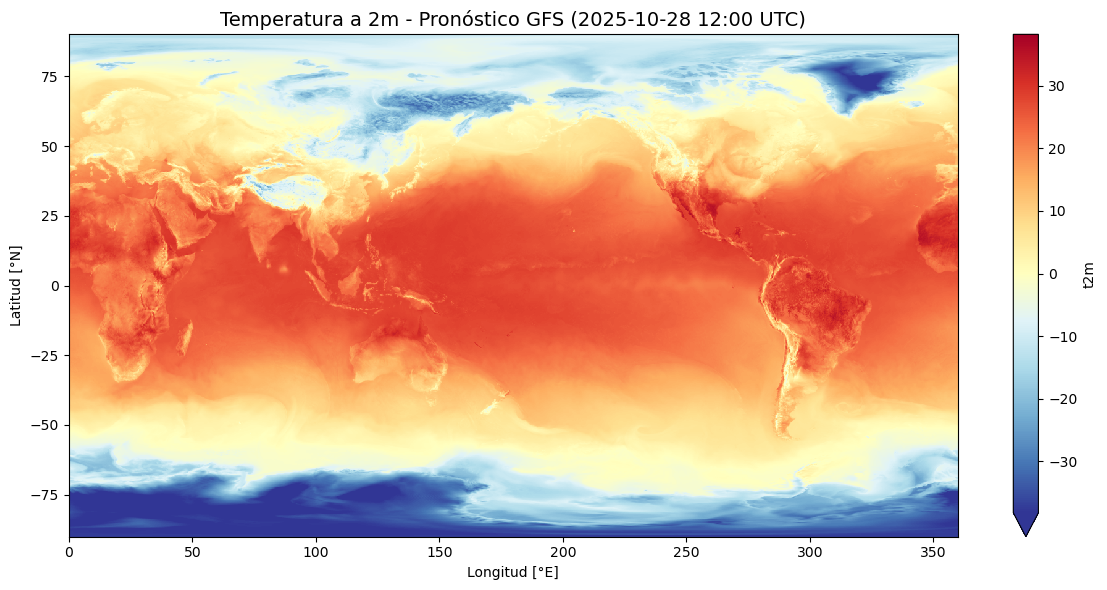

In [22]:
# Creamos una visualizacion 
fig, ax = plt.subplots(figsize=(12, 6))
t2m_celsius.isel(step=10).plot(ax=ax, x="longitude", y="latitude", cmap="RdYlBu_r", robust=True)
ax.set_title(f"Temperatura a 2m - Pronóstico GFS ({fecha_str} 12:00 UTC)", fontsize=14)
ax.set_xlabel("Longitud [°E]")
ax.set_ylabel("Latitud [°N]")
plt.tight_layout()
plt.show()

### 3.2. 🇨🇴 Pronóstico regional para Colombia

Ahora extraigamos y visualicemos el pronóstico para Colombia usando una proyección apropiada.

In [25]:
# Seleccionar región de Colombia
# Longitud: 275° a 300° (equivalente a -85° a -60°)
# Latitud: 14° a -5° (Norte a Sur)
gfs_colombia = ds_gfs.sel(
    longitude=slice(275, 300),
    latitude=slice(14, -5)).sel(
    time=f"{fecha_str} 12:00",
    method="nearest"
)

print(f"Shape Colombia: {gfs_colombia.t2m.shape}")

Shape Colombia: (101, 77, 209)


In [26]:
gfs_colombia

<xarray.Dataset> Size: 33MB
Dimensions:    (longitude: 101, latitude: 77, step: 209)
Coordinates:
  * longitude  (longitude) float64 808B 275.0 275.2 275.5 ... 299.5 299.8 300.0
  * latitude   (latitude) float64 616B 14.0 13.75 13.5 13.25 ... -4.5 -4.75 -5.0
  * step       (step) timedelta64[h] 2kB 00:00:00 01:00:00 ... 16 days 00:00:00
    time       datetime64[ns] 8B 2025-10-27T12:00:00
Data variables:
    r2         (longitude, latitude, step) float32 7MB dask.array<chunksize=(101, 56, 24), meta=np.ndarray>
    prate      (longitude, latitude, step) float32 7MB dask.array<chunksize=(101, 56, 24), meta=np.ndarray>
    t2m        (longitude, latitude, step) float32 7MB dask.array<chunksize=(101, 56, 24), meta=np.ndarray>
    gust       (longitude, latitude, step) float32 7MB dask.array<chunksize=(101, 56, 24), meta=np.ndarray>
    tcc        (longitude, latitude, step) float32 7MB dask.array<chunksize=(101, 56, 24), meta=np.ndarray>
Attributes:
    description:  GFS data ingested for forecasting demo

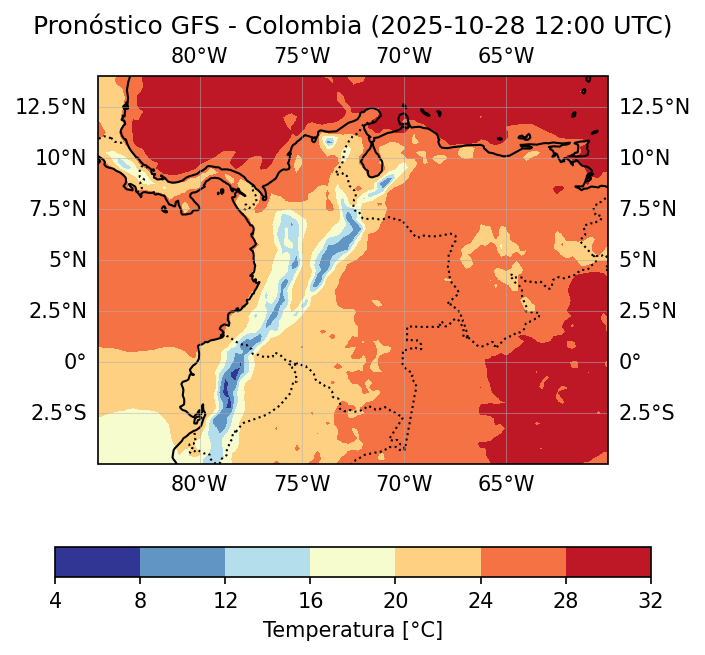

In [31]:
# Crear mapa para Colombia con proyección PlateCarree
fig, ax = plt.subplots(
    # figsize=(10, 8),
    subplot_kw={"projection": ccrs.PlateCarree()},
    dpi=150
)

# Temperatura en Celsius
t2m_col = gfs_colombia.t2m - 273.15

# Graficar temperatura
t2m_col.isel(step=0).plot.contourf(
    ax=ax,
    x="longitude", 
    y="latitude",
    cmap="RdYlBu_r",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "label": "Temperatura [°C]",
        "orientation": "horizontal",
        "shrink": 0.8
    }
)

# Añadir características geográficas
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)

ax.set_title(f"Pronóstico GFS - Colombia ({fecha_str} 12:00 UTC)", fontsize=12)
plt.show()

### 3.3. 📊 Múltiples variables para Colombia

Visualicemos varias variables meteorológicas simultáneamente.

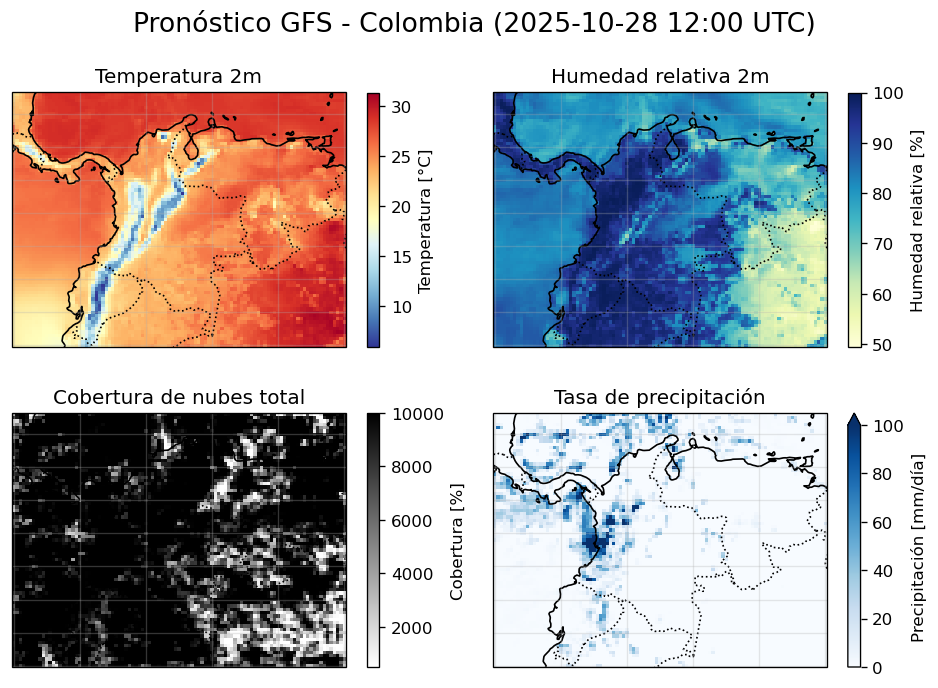

In [42]:
# Crear panel con 4 variables
fig, axes = plt.subplots(
    2, 2,
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()},
    dpi=120
)
axes = axes.flatten()

# Variable 1: Temperatura
(gfs_colombia.t2m.isel(step=0) - 273.15).plot(
    x="longitude", y="latitude",
    ax=axes[0], cmap="RdYlBu_r", transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperatura [°C]", "shrink": 0.8}
)
axes[0].set_title("Temperatura 2m")

# Variable 2: Humedad relativa
gfs_colombia.r2.isel(step=0).plot(
    x="longitude", y="latitude",
    ax=axes[1], cmap="YlGnBu", transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Humedad relativa [%]", "shrink": 0.8}
)
axes[1].set_title("Humedad relativa 2m")

# Variable 3: Cobertura de nubes
(gfs_colombia.isel(step=0).tcc * 100).plot(
    x="longitude", y="latitude",
    ax=axes[2], cmap="gray_r", transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Cobertura [%]", "shrink": 0.8}
)
axes[2].set_title("Cobertura de nubes total")

# Variable 4: Precipitación
(gfs_colombia.isel(step=0).prate * 86400).plot(  # Convertir a mm/día
    x="longitude", y="latitude",
    ax=axes[3], cmap="Blues", transform=ccrs.PlateCarree(),
    vmin=0, vmax=100,
    cbar_kwargs={"label": "Precipitación [mm/día]", "shrink": 0.8}
)
axes[3].set_title("Tasa de precipitación")

# Añadir características a todos los mapas
for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.gridlines(alpha=0.3)

plt.suptitle(f"Pronóstico GFS - Colombia ({fecha_str} 12:00 UTC)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## 4. ⏱️ Series temporales de pronóstico

Extraigamos una serie temporal del pronóstico para una ciudad específica.

### 4.1. 📈 Pronóstico para Bogotá

Extraigamos el pronóstico de temperatura para Bogotá durante los próximos 7 días.

In [50]:
# Coordenadas de Bogotá: 4.7°N, 285.9°E (-74.1°W)
today = datetime.now()
week_ahead = timedelta(hours=168)

t2m_bogota = ds_gfs.t2m.sel(
    latitude=4.7,
    longitude=285.9,
    time=f"{today}",
    method="nearest"
).sel(step=slice(None, week_ahead))

# Convertir a Celsius
t2m_bogota_celsius = t2m_bogota - 273.15

print(f"Pronóstico para Bogotá: {len(t2m_bogota_celsius)} pasos de tiempo")

Pronóstico para Bogotá: 137 pasos de tiempo


In [51]:
t2m_bogota

<xarray.DataArray 't2m' (step: 137)> Size: 548B
dask.array<getitem, shape=(137,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
  * step       (step) timedelta64[h] 1kB 00:00:00 01:00:00 ... 7 days 00:00:00
    latitude   float64 8B 4.75
    longitude  float64 8B 286.0
    time       datetime64[ns] 8B 2025-10-27T12:00:00
Attributes: (12/35)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_stepRange:                           0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature
    grid_mapping:                             gribfile_projection

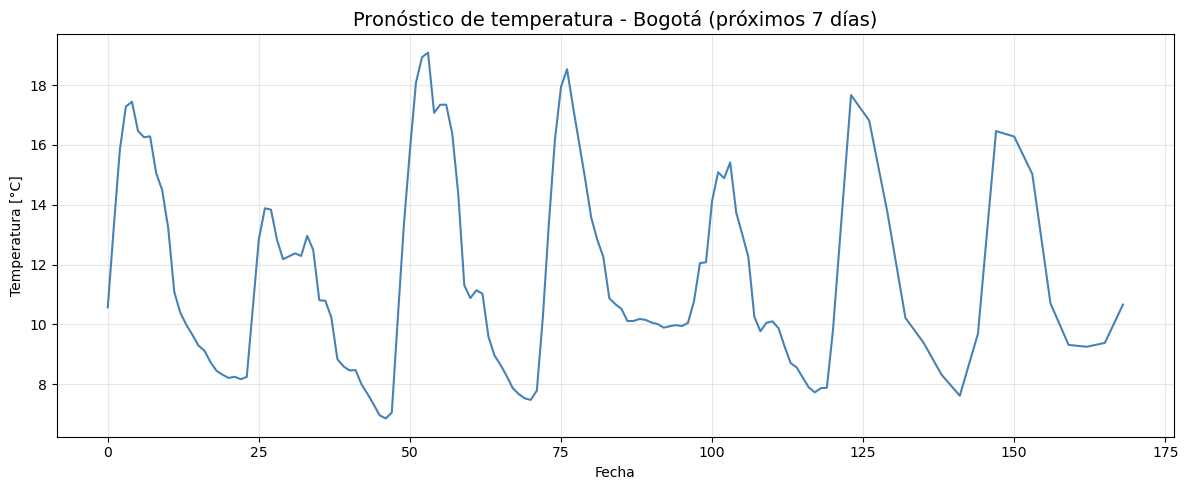

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))

t2m_bogota_celsius.plot(ax=ax, linewidth=1.5, color="steelblue")

ax.set_title("Pronóstico de temperatura - Bogotá (próximos 7 días)", fontsize=14)
ax.set_xlabel("Fecha")
ax.set_ylabel("Temperatura [°C]")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## ✏️ Ejercicios

### Ejercicio 1: Explora otra variable

**Objetivo**: Practicar visualización de otras variables del GFS.

**Tareas**:
1. Genera un mapa de ráfagas de viento (`gust`) para Colombia
2. Calcula la precipitación acumulada de 24 horas
3. Visualiza la evolución temporal de nubosidad para Medellín (lat=6.25, lon=284.5)

In [ ]:
# Tu código aquí

```{admonition} 💡 Solución
:class: dropdown

A continuación se presenta una posible solución para los tres ejercicios:
```

In [ ]:
# Tarea 1: Mapa de ráfagas de viento para Colombia
fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=120
)

# Seleccionar ráfagas de viento
gust_col = gfs_colombia.gust.isel(step=0)

# Graficar
gust_col.plot(
    x='longitude',
    y='latitude',
    ax=ax,
    cmap='YlOrRd',
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Ráfagas de viento [m/s]', 'shrink': 0.8}
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
ax.set_title(f'Pronóstico de ráfagas de viento - Colombia ({fecha_str} 12:00 UTC)')
plt.show()

In [ ]:
# Tarea 2: Precipitación acumulada de 24 horas
# Seleccionar las primeras 24 horas de pronóstico
precip_24h = gfs_colombia.prate.isel(step=slice(0, 24))

# Convertir de kg/m²/s a mm/día y sumar sobre 24 horas
# 1 kg/m²/s * 3600 s/h = mm/h, luego sumar 24 horas
precip_acum_24h = (precip_24h * 3600).sum(dim='step')

# Visualizar
fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=120
)

precip_acum_24h.plot(
    x='longitude',
    y='latitude',
    ax=ax,
    cmap='Blues',
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Precipitación acumulada [mm]', 'shrink': 0.8}
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
ax.set_title(f'Precipitación acumulada 24h - Colombia ({fecha_str})')
plt.show()

print(f'Precipitación máxima en 24h: {float(precip_acum_24h.max().values):.1f} mm')

In [ ]:
# Tarea 3: Evolución temporal de nubosidad para Medellín
# Coordenadas: lat=6.25, lon=284.5 (equivalente a -75.5°W)
week_ahead = timedelta(hours=168)

tcc_medellin = ds_gfs.tcc.sel(
    latitude=6.25,
    longitude=284.5,
    time=f"{today}",
    method='nearest'
).sel(step=slice(None, week_ahead))

# Convertir a porcentaje
tcc_medellin_pct = tcc_medellin * 100

# Visualizar
fig, ax = plt.subplots(figsize=(12, 5))

tcc_medellin_pct.plot(ax=ax, linewidth=1.5, color='gray')

ax.set_title('Pronóstico de cobertura de nubes - Medellín (próximos 7 días)', fontsize=14)
ax.set_xlabel('Paso de tiempo')
ax.set_ylabel('Cobertura de nubes [%]')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50% cobertura')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Cobertura promedio: {float(tcc_medellin_pct.mean().values):.1f}%')
print(f'Cobertura máxima: {float(tcc_medellin_pct.max().values):.1f}%')
print(f'Cobertura mínima: {float(tcc_medellin_pct.min().values):.1f}%')

```

**Notas sobre la solución:**

- **Tarea 1**: Utilizamos el colormap `'YlOrRd'` (amarillo-naranja-rojo) apropiado para ráfagas de viento
- **Tarea 2**: Convertimos `prate` (kg/m²/s) a mm acumulados multiplicando por 3600 s/h y sumando sobre 24 pasos horarios
- **Tarea 3**: Graficamos la evolución temporal de nubosidad con una línea de referencia en 50% de cobertura

💡 **Pista**: Experimenta modificando los rangos de tiempo (`step`) o seleccionando diferentes ubicaciones para explorar distintas condiciones meteorológicas.

---

## ✅ Resumen

En este cuaderno aprendimos a:

✔️ Comprender las características del modelo GFS y su importancia operacional
✔️ Acceder a pronósticos GFS mediante ArrayLake en formato Zarr
✔️ Explorar variables de superficie relevantes para meteorología
✔️ Generar mapas regionales de pronóstico con proyecciones cartográficas
✔️ Extraer y visualizar series temporales para ubicaciones específicas

```{tip}
GFS es ampliamente utilizado como condición inicial para modelos regionales. Estas técnicas son fundamentales para pronóstico meteorológico operacional.
```

## 🚀 ¿Qué sigue?

Con los conocimientos sobre pronósticos GFS, puedes explorar:

- **[3.3. Datos de reanálisis ERA5](../3.Aplicaciones/3.3.ERA5.ipynb)** - Comparar pronósticos con reanálisis
- **[2.1. Estaciones](2.1.Estaciones.ipynb)** - Validar pronósticos con observaciones
- **Modelos regionales** - Usar GFS como condición inicial para WRF

### Proyecto sugerido:

Desarrolla un sistema de monitoreo que:
1. Descargue el último pronóstico GFS cada 6 horas
2. Genere mapas automáticos para Colombia
3. Compare con observaciones de estaciones del IDEAM
4. Calcule métricas de error (RMSE, bias) del pronóstico

## 📚 Recursos y referencias

- [GFS Documentation - NCEP/EMC](https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php)
- [ArrayLake GFS Dataset](https://app.earthmover.io/earthmover-public/gfs)
- [Earthmover GFS Documentation](https://docs.earthmover.io/sample-data/gfs)
- [FV3 Cubed-Sphere Grid](https://www.gfdl.noaa.gov/fv3/fv3-grids/)
- [Zarr v3 documentation](https://zarr.readthedocs.io/en/stable/)
- [Cartopy documentation](https://scitools.org.uk/cartopy/docs/latest/)